# Result processing for master thesis

We want to test 2 things:

- Q1: Can we predict the flipping of a condition:
Can we predict based on a set of metrics IF we will flip a branch (classification in flip or no flip)

- Q2: Is there a strategy which performs better than other strategies:
Can we predict based on a set of metrics WHICH strategy we can use to optimize the time spend on the branch. (classification on strategy with time metric to optimize)

## Importing data

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

STRATEGIES = ['GradientDescentStrategy', 'MagicByteStrategy' , 'OneByteStrategy', 'LengthTaintStrategy', 'ConcolicStrategy', 'RandomStrategy', 'RandomTaintStrategy']
VARIABLES_TO_TEST = ['oviedo', 'cyclomatic' , 'nrOfOffsets', 'cases', 'chain_size', 'depth2', 'trace_length']
PROGRAMS = ["gif2png", 
"file", "nm", "djpeg", "jhead", "xmlwf", "tcpdump"
]

all_data = []
for program in PROGRAMS:
    print("Reading " + "../results/%s/raw_data.csv" % program)
    program_data = pd.read_csv("../results/%s/raw_data.csv" % program, index_col=False)
    program_data["program"] = program
    all_data.append(program_data)
data = pd.concat(all_data)
#set right types
data["program"] = data["program"].astype('category')
data["status"] = data["status"].astype('category')
data["Strategy"] = data["Strategy"].astype('category')

#add new column
data["relative_depth"] = data["depth2"]/data["trace_length"]
print("done")
data.info()

Reading ../results/gif2png/raw_data.csv
Reading ../results/file/raw_data.csv
Reading ../results/nm/raw_data.csv
Reading ../results/djpeg/raw_data.csv
Reading ../results/jhead/raw_data.csv
Reading ../results/xmlwf/raw_data.csv
Reading ../results/tcpdump/raw_data.csv
done
<class 'pandas.core.frame.DataFrame'>
Int64Index: 314090 entries, 0 to 51505
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Strategy        314090 non-null  category
 1   id              314090 non-null  object  
 2   cmpid           314090 non-null  int64   
 3   nrOfMisses      314090 non-null  int64   
 4   nrOfInputs      314090 non-null  int64   
 5   depth           314090 non-null  int64   
 6   status          314090 non-null  category
 7   totalTime       314090 non-null  float64 
 8   nrOfOffsets     314090 non-null  int64   
 9   cyclomatic      314090 non-null  object  
 10  oviedo          314090 non-null  object  
 11  cha

In [43]:
data.groupby(["program"]).describe()

,cmpid,nrOfMisses,nrOfInputs,depth,totalTime,nrOfOffsets,depth2,trace_length,flipped,relative_depth
count,3.140900e+05,314090.000000,314090.000000,314090.000000,314090.000000,314090.000000,314090.000000,314090.000000,314090.000000,314090.000000
mean,1.996719e+09,458.444350,754.363956,2184.193002,0.360766,3.529909,2184.193002,3943.250167,0.199669,0.676210
std,1.011726e+09,1862.373122,2658.874245,2302.355746,1.693771,7.520440,2302.355746,4295.691079,0.399752,0.283165
min,1.771752e+06,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.452827e+09,0.000000,0.000000,490.000000,0.000051,1.000000,490.000000,1044.000000,0.000000,0.413324
50%,1.693429e+09,0.000000,2.000000,1368.000000,0.002830,1.000000,1368.000000,2385.000000,0.000000,0.774501
75%,2.879473e+09,35.000000,365.000000,3012.000000,0.072575,4.000000,3012.000000,4758.000000,0.000000,0.927105
max,4.288922e+09,31259.000000,32851.000000,14048.000000,15.272965,509.000000,14048.000000,14158.000000,1.000000,0.999929


## Inspect data

We will look at the number of flips per strategy per binary

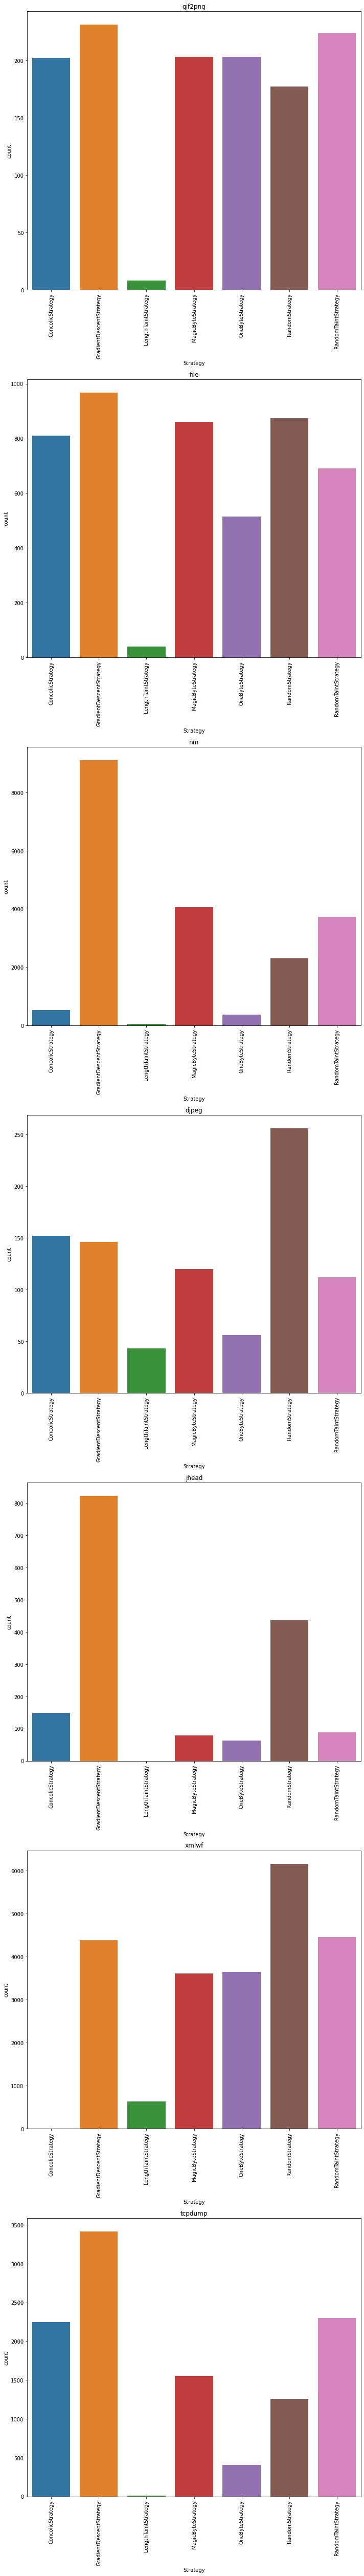

In [14]:

df = data
programs = df.program.unique()
fig, axs = plt.subplots(nrows=int(programs.size), ncols=1, figsize =(10, df["Strategy"].unique().size*10))
axs = axs.flatten()
for ax, program in zip(axs,programs):
    ax = sns.countplot(x="Strategy", data=df[ (df["program"] == program) & (df["flipped"] == 1)], order=df.Strategy.cat.categories,  ax=ax)
    ax.set_xticklabels(df.Strategy.cat.categories, rotation = 90)
    ax.set_title(program)
plt.tight_layout()

### Look at the relations between the variables
We will filter the values of - from the data and try to see some relations

In [72]:
columns = ['relative_depth', 'program', 'flipped', 'id', 'Strategy']
columns += VARIABLES_TO_TEST
df_copy = df[columns].copy()
for column in columns:
    df_copy = df_copy[df_copy[column] != '-']
programs = df_copy.program.unique()
for variable in ['oviedo', 'cyclomatic', 'cases', 'chain_size']:
    df_copy[variable] = df_copy[variable].astype('int')

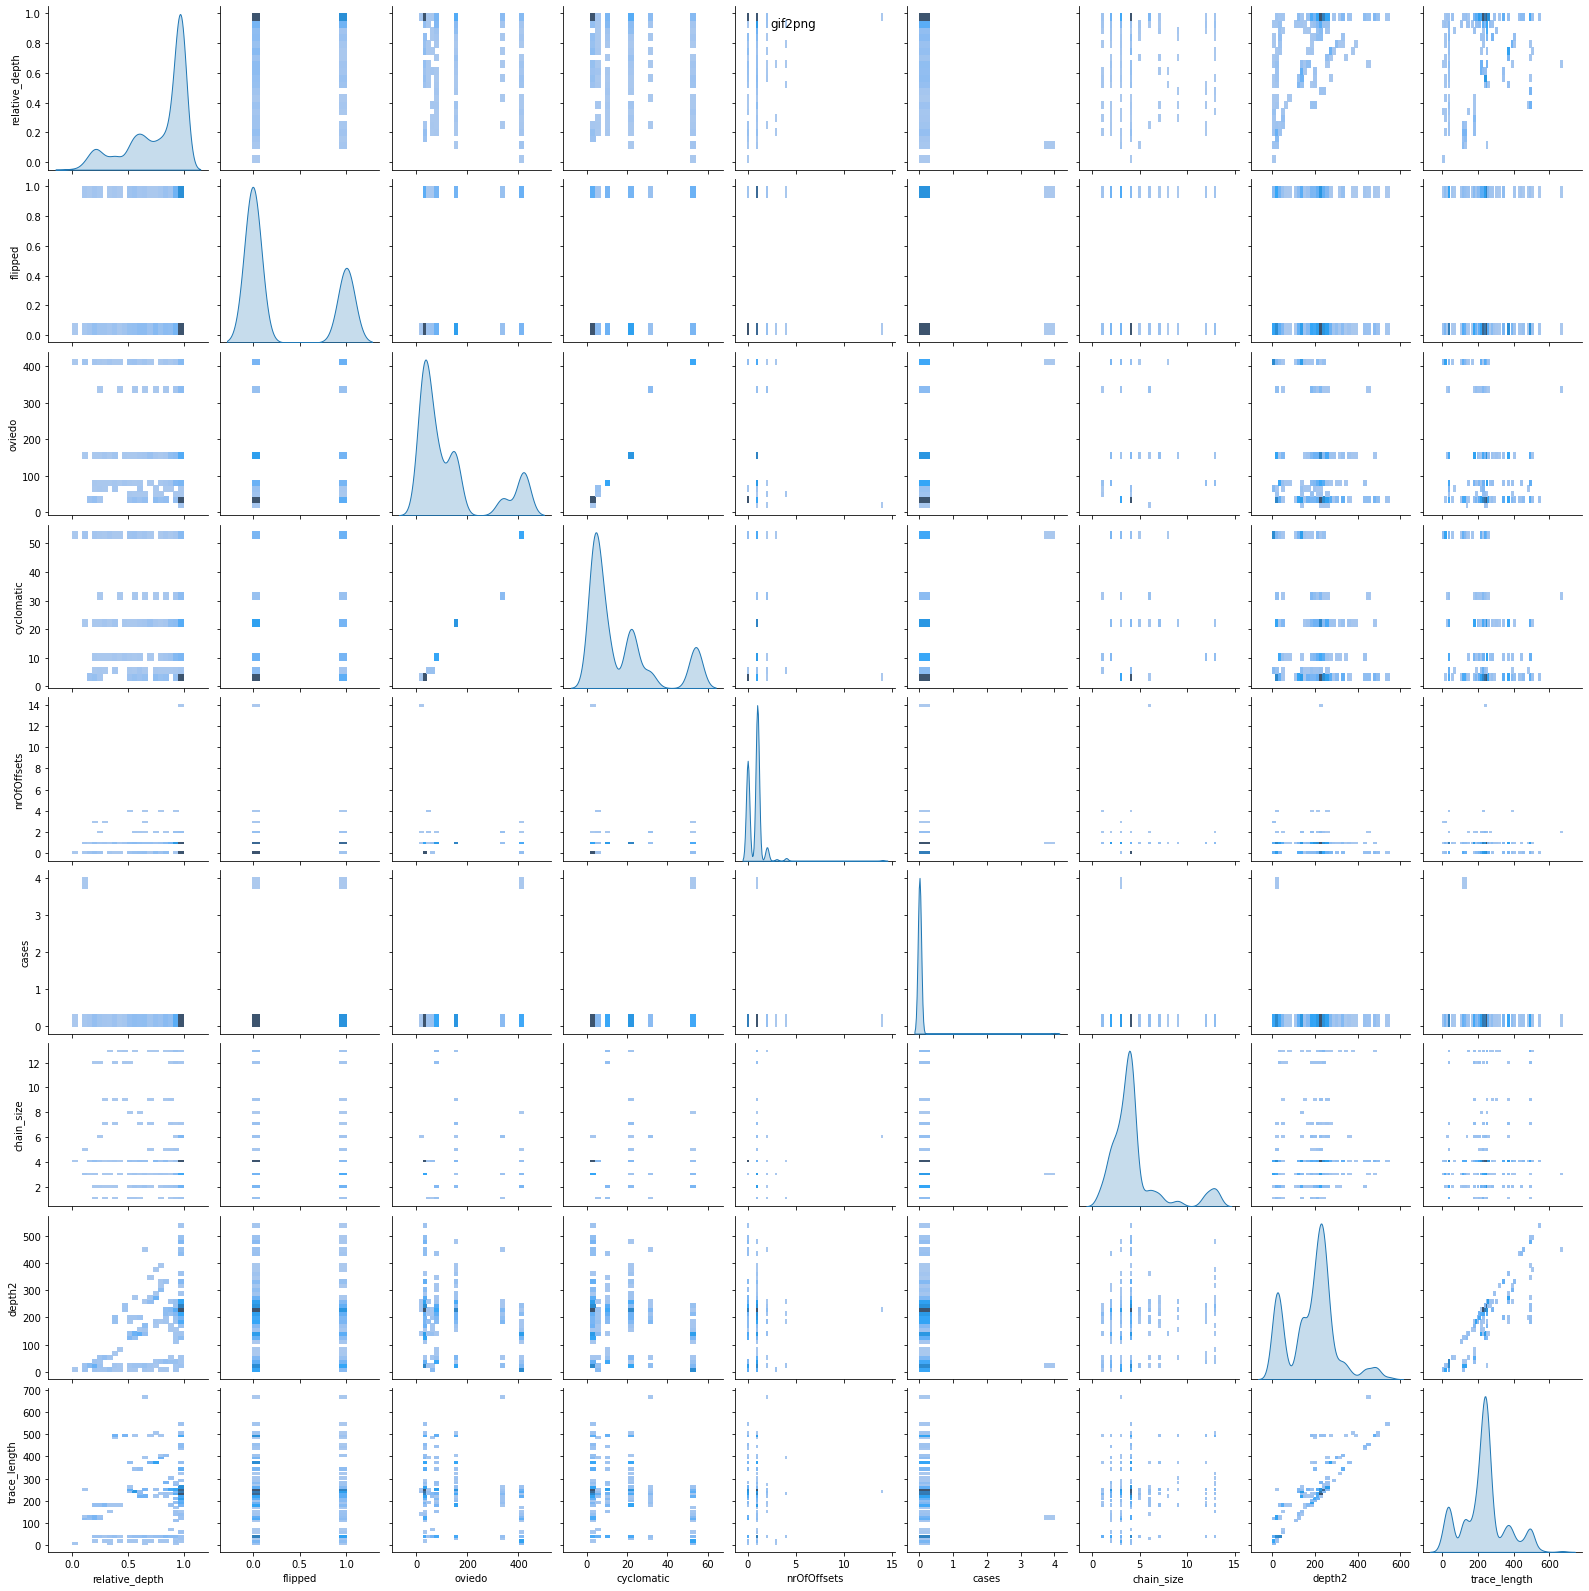

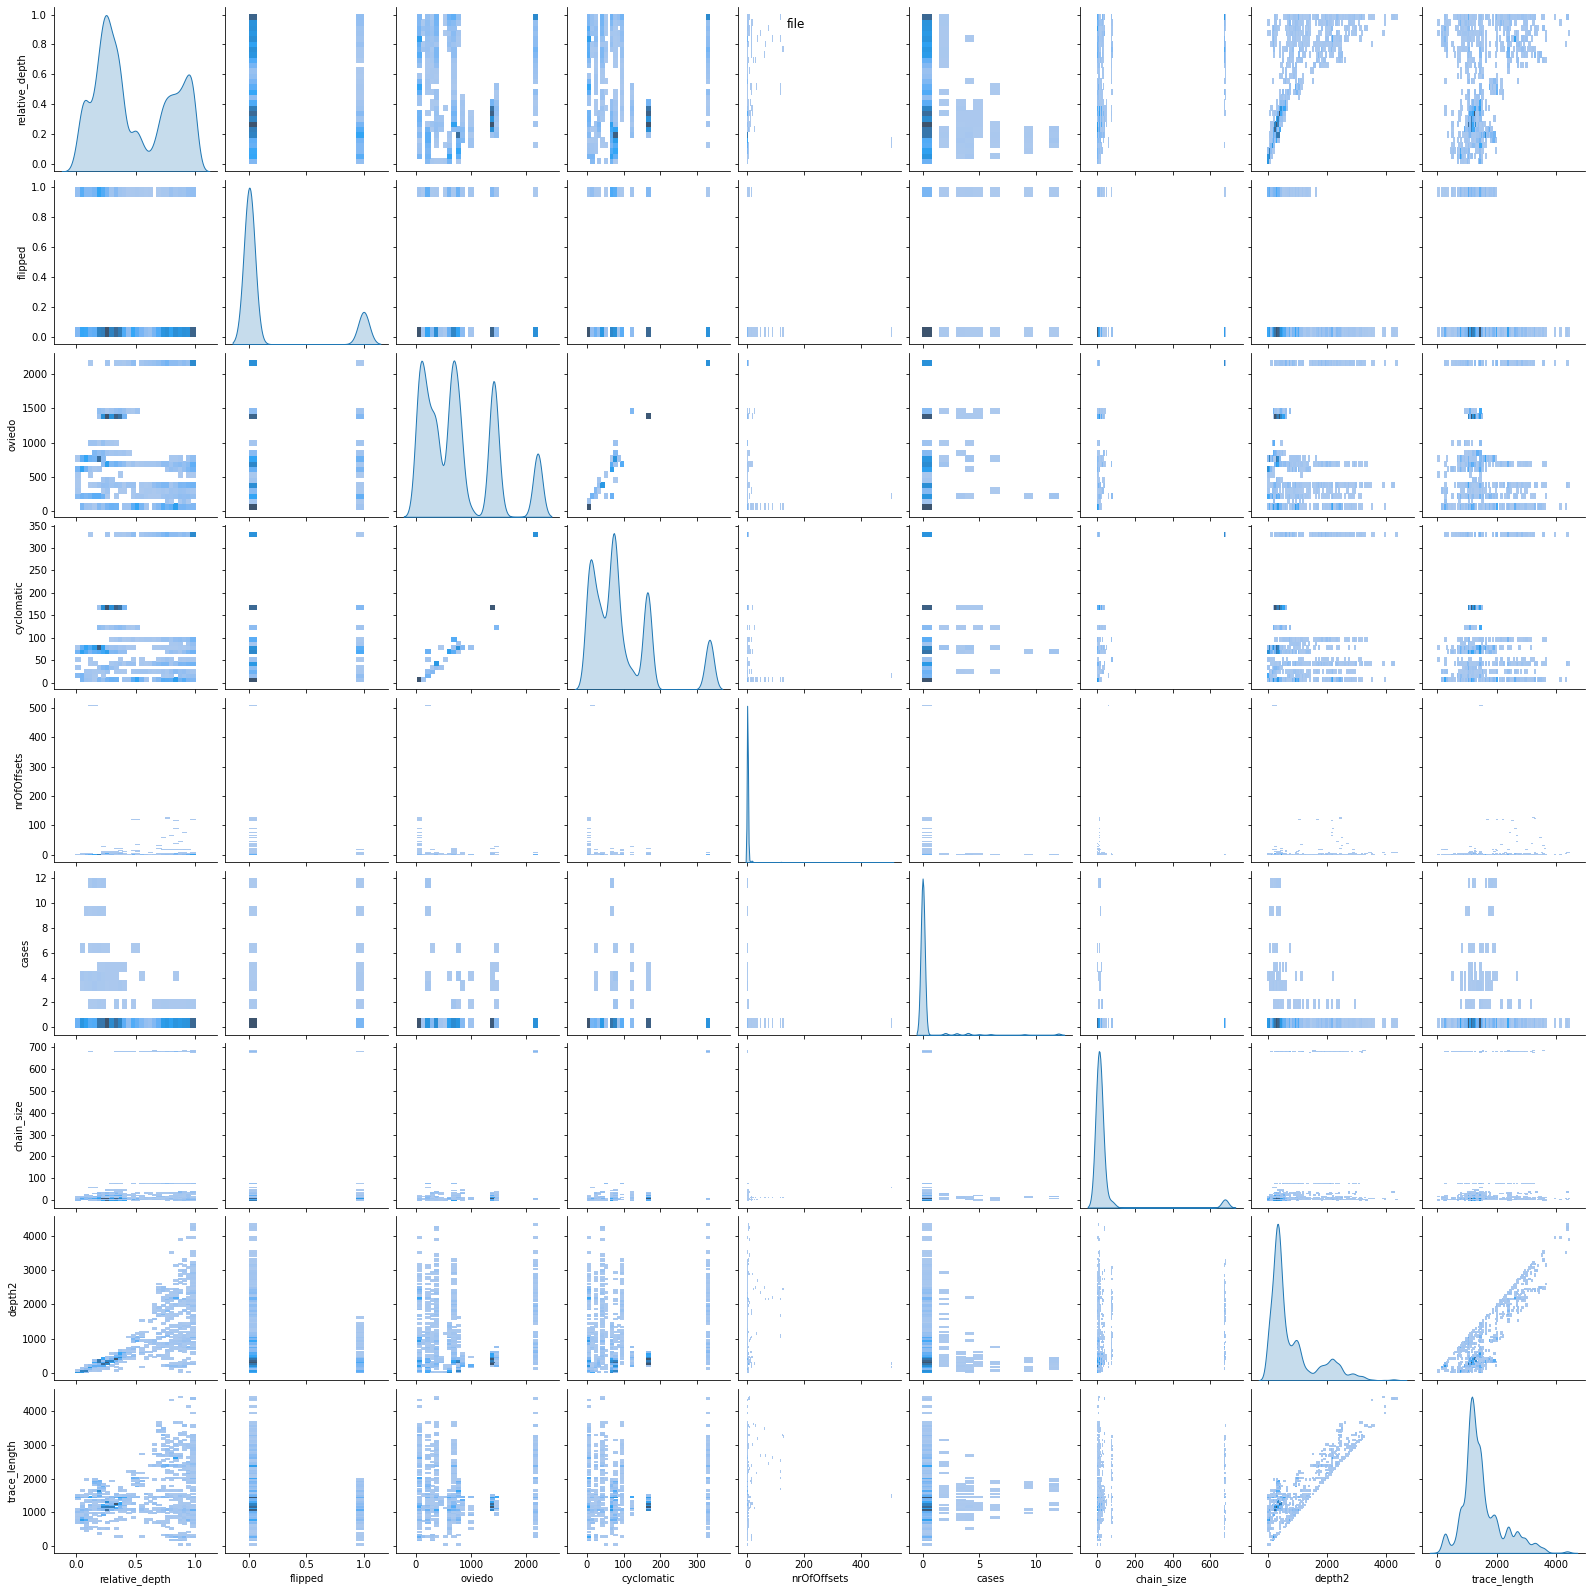

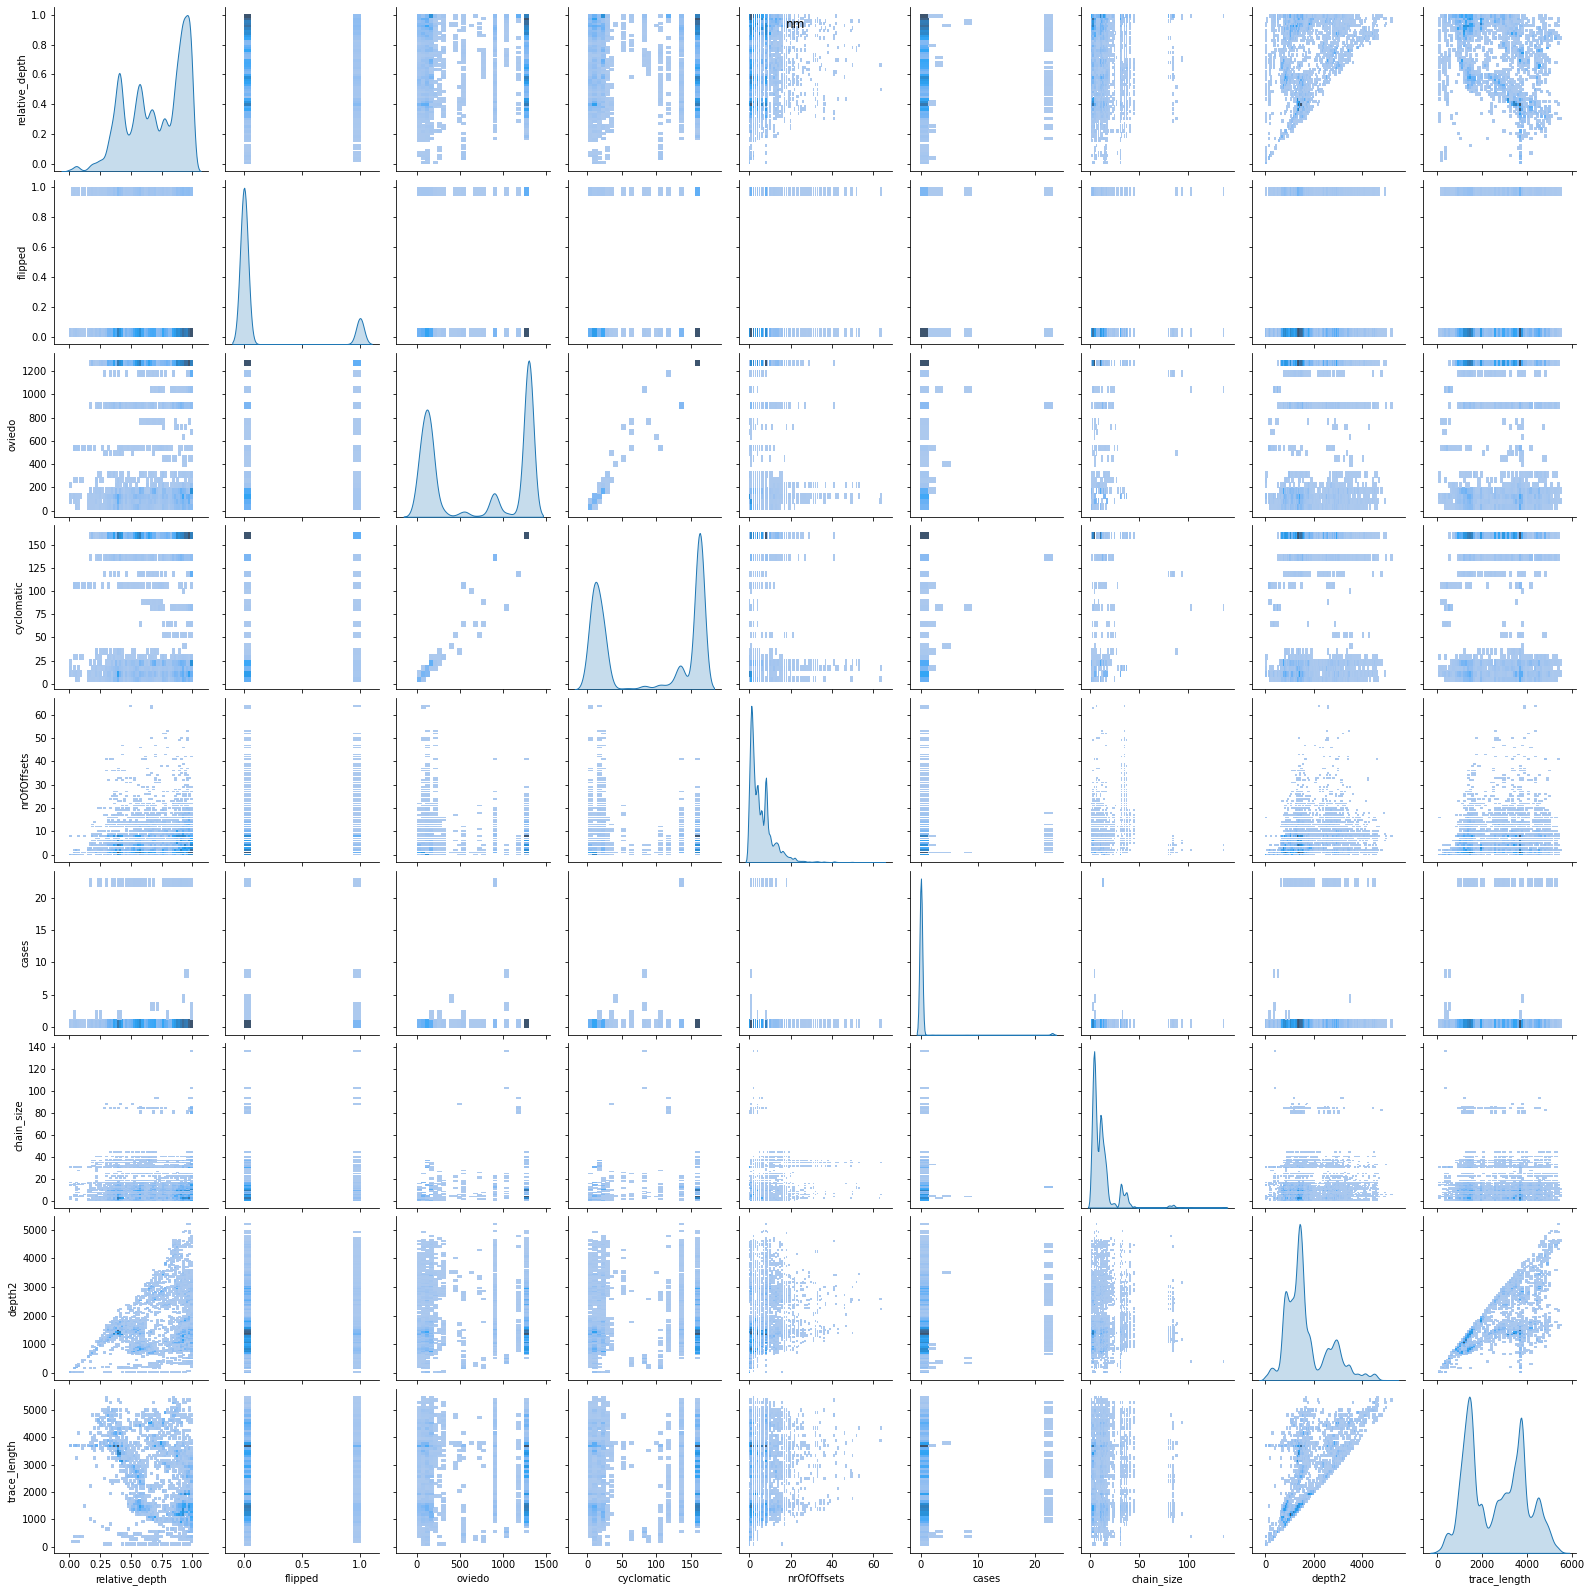

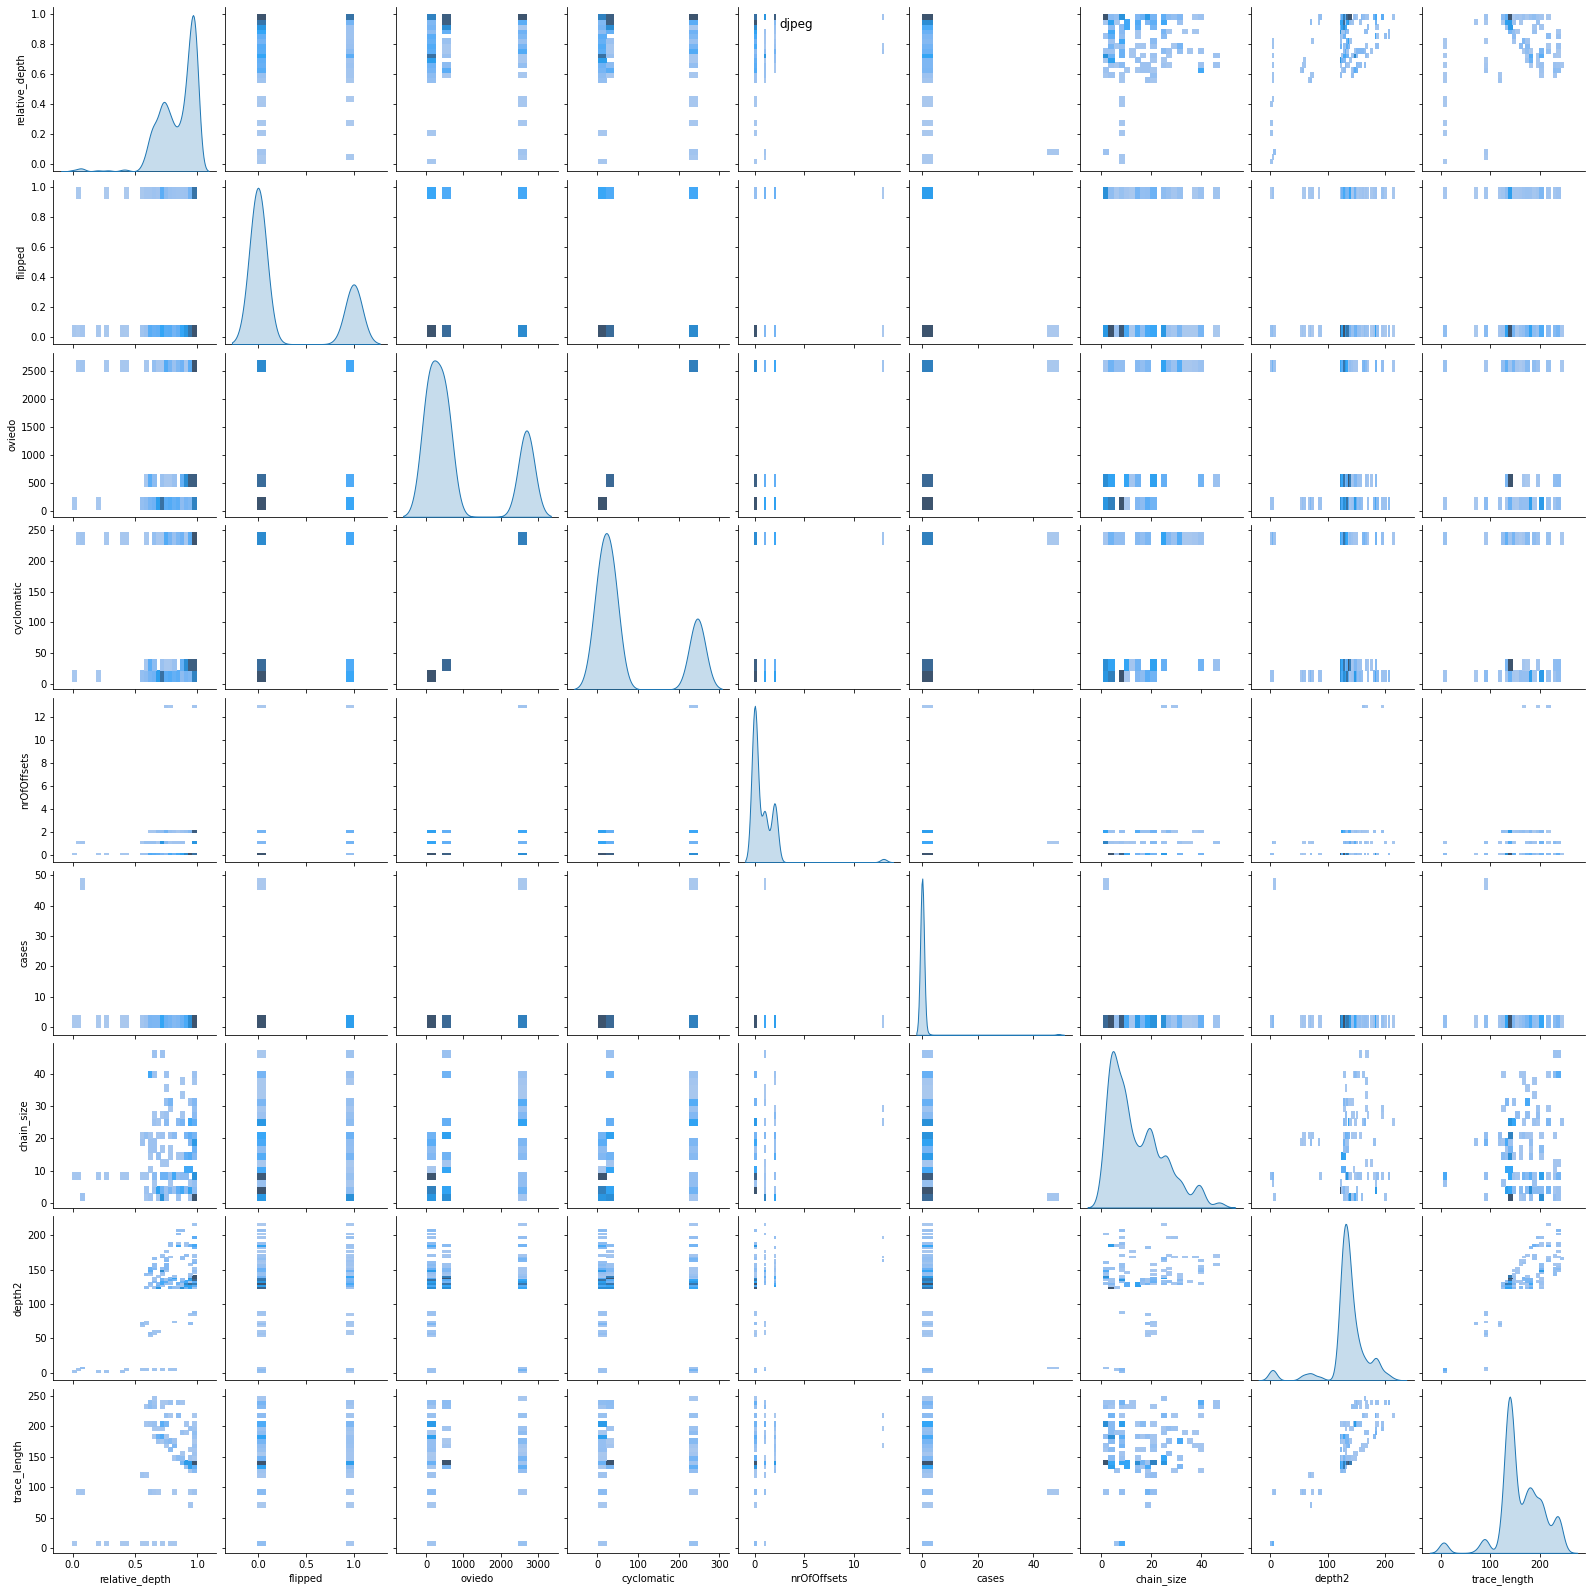

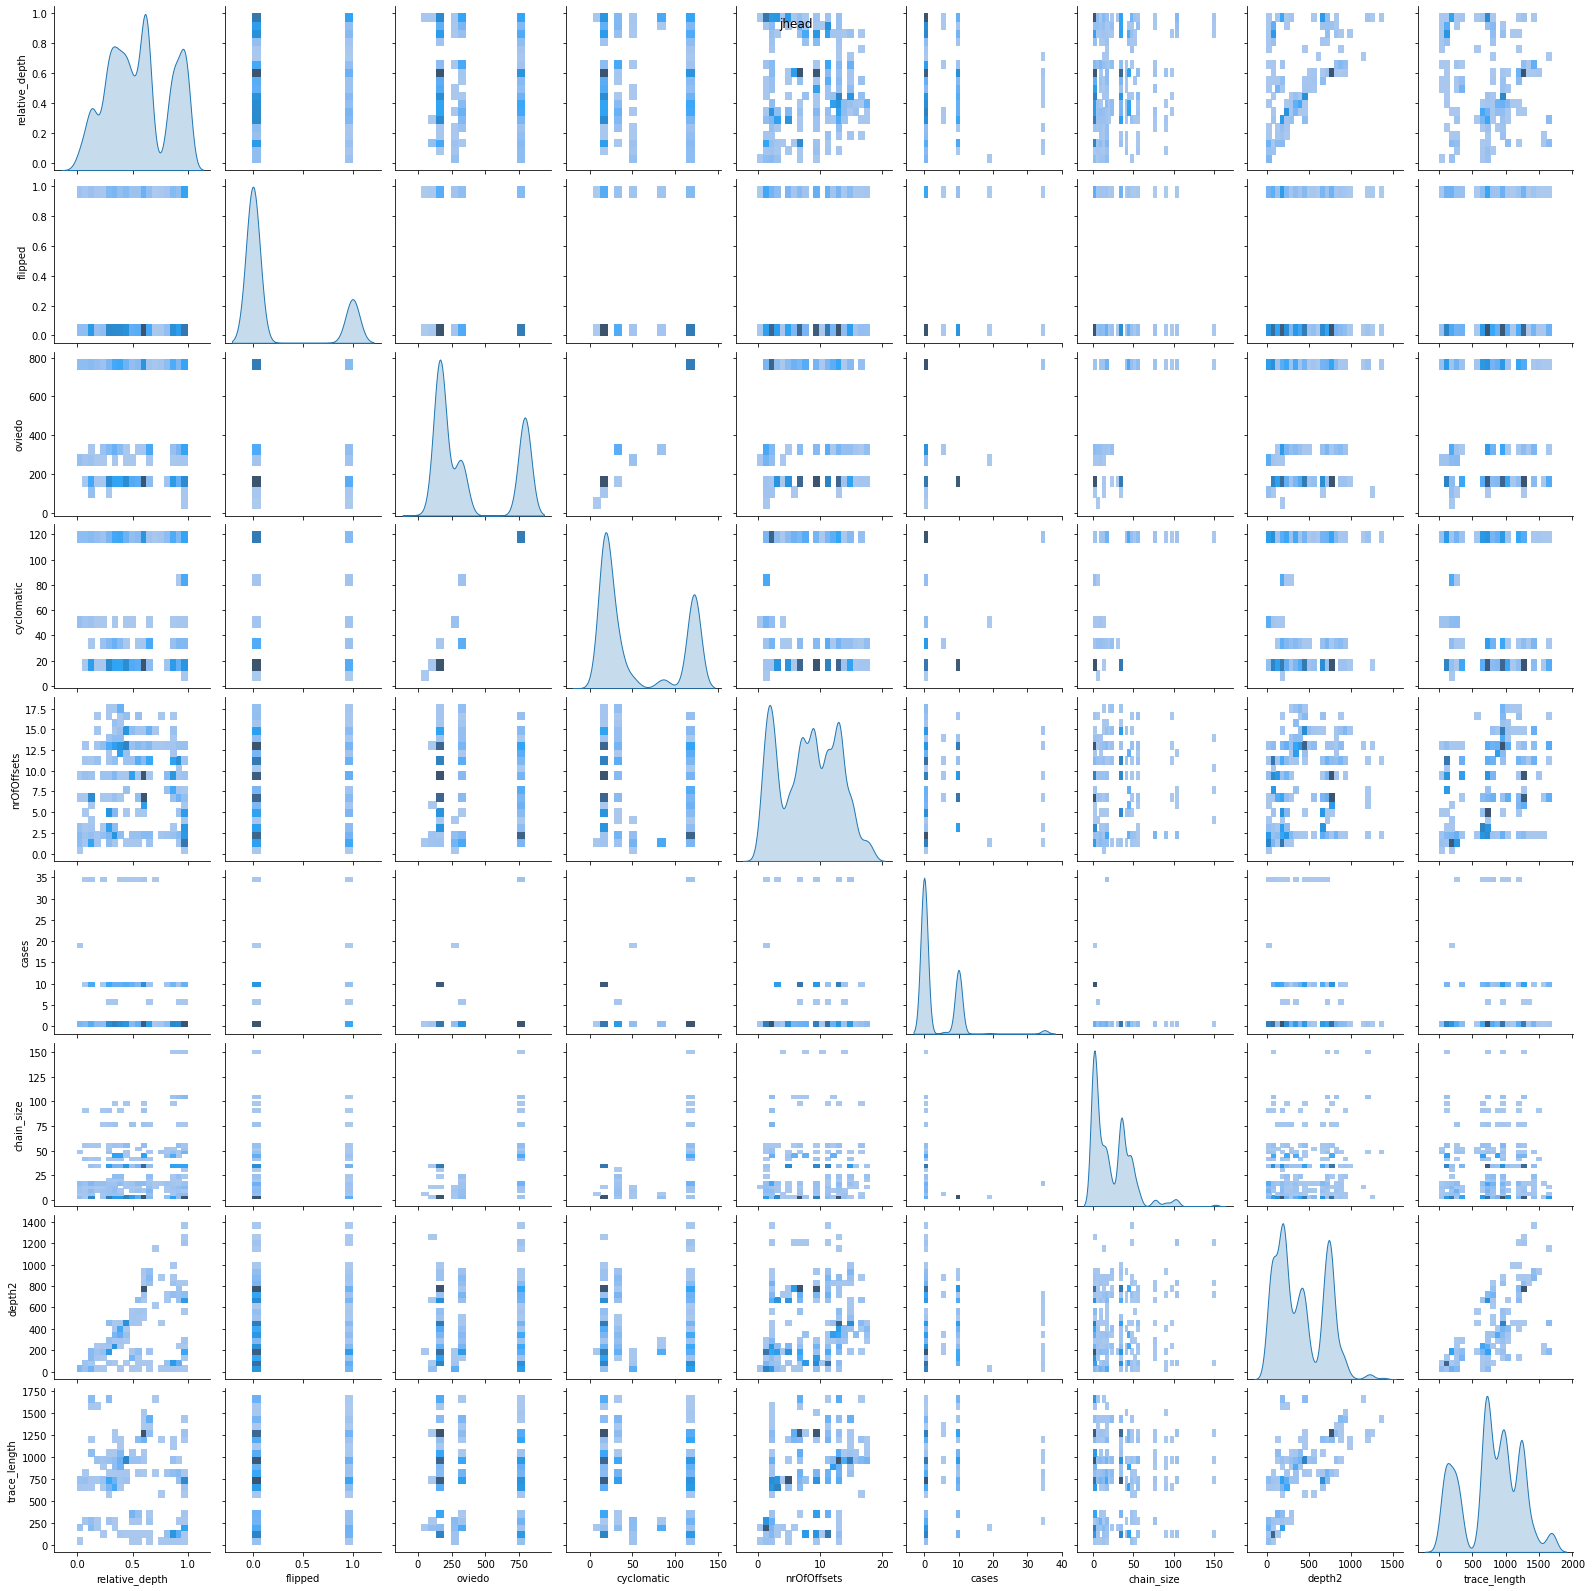

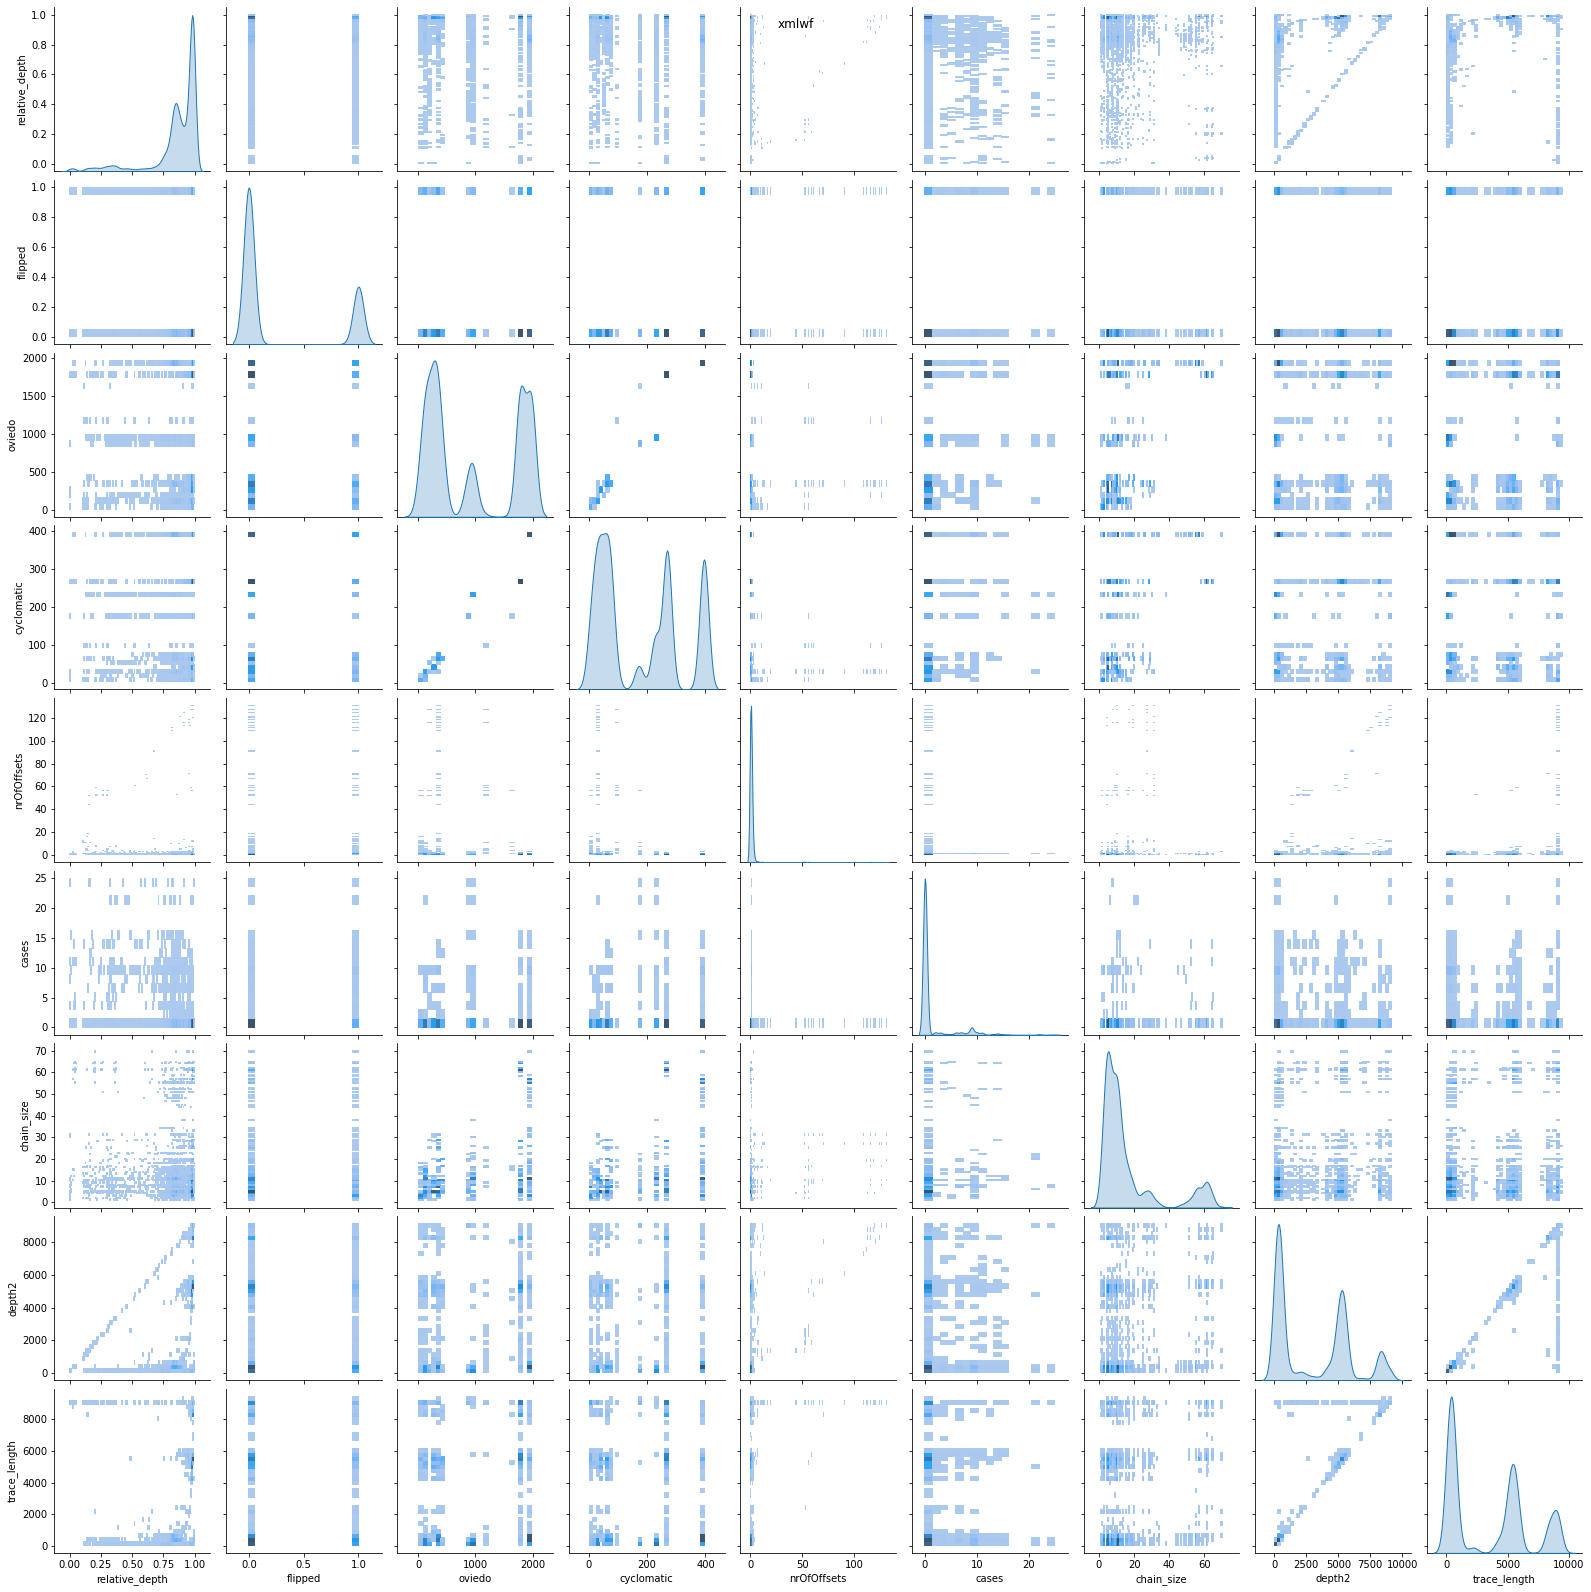

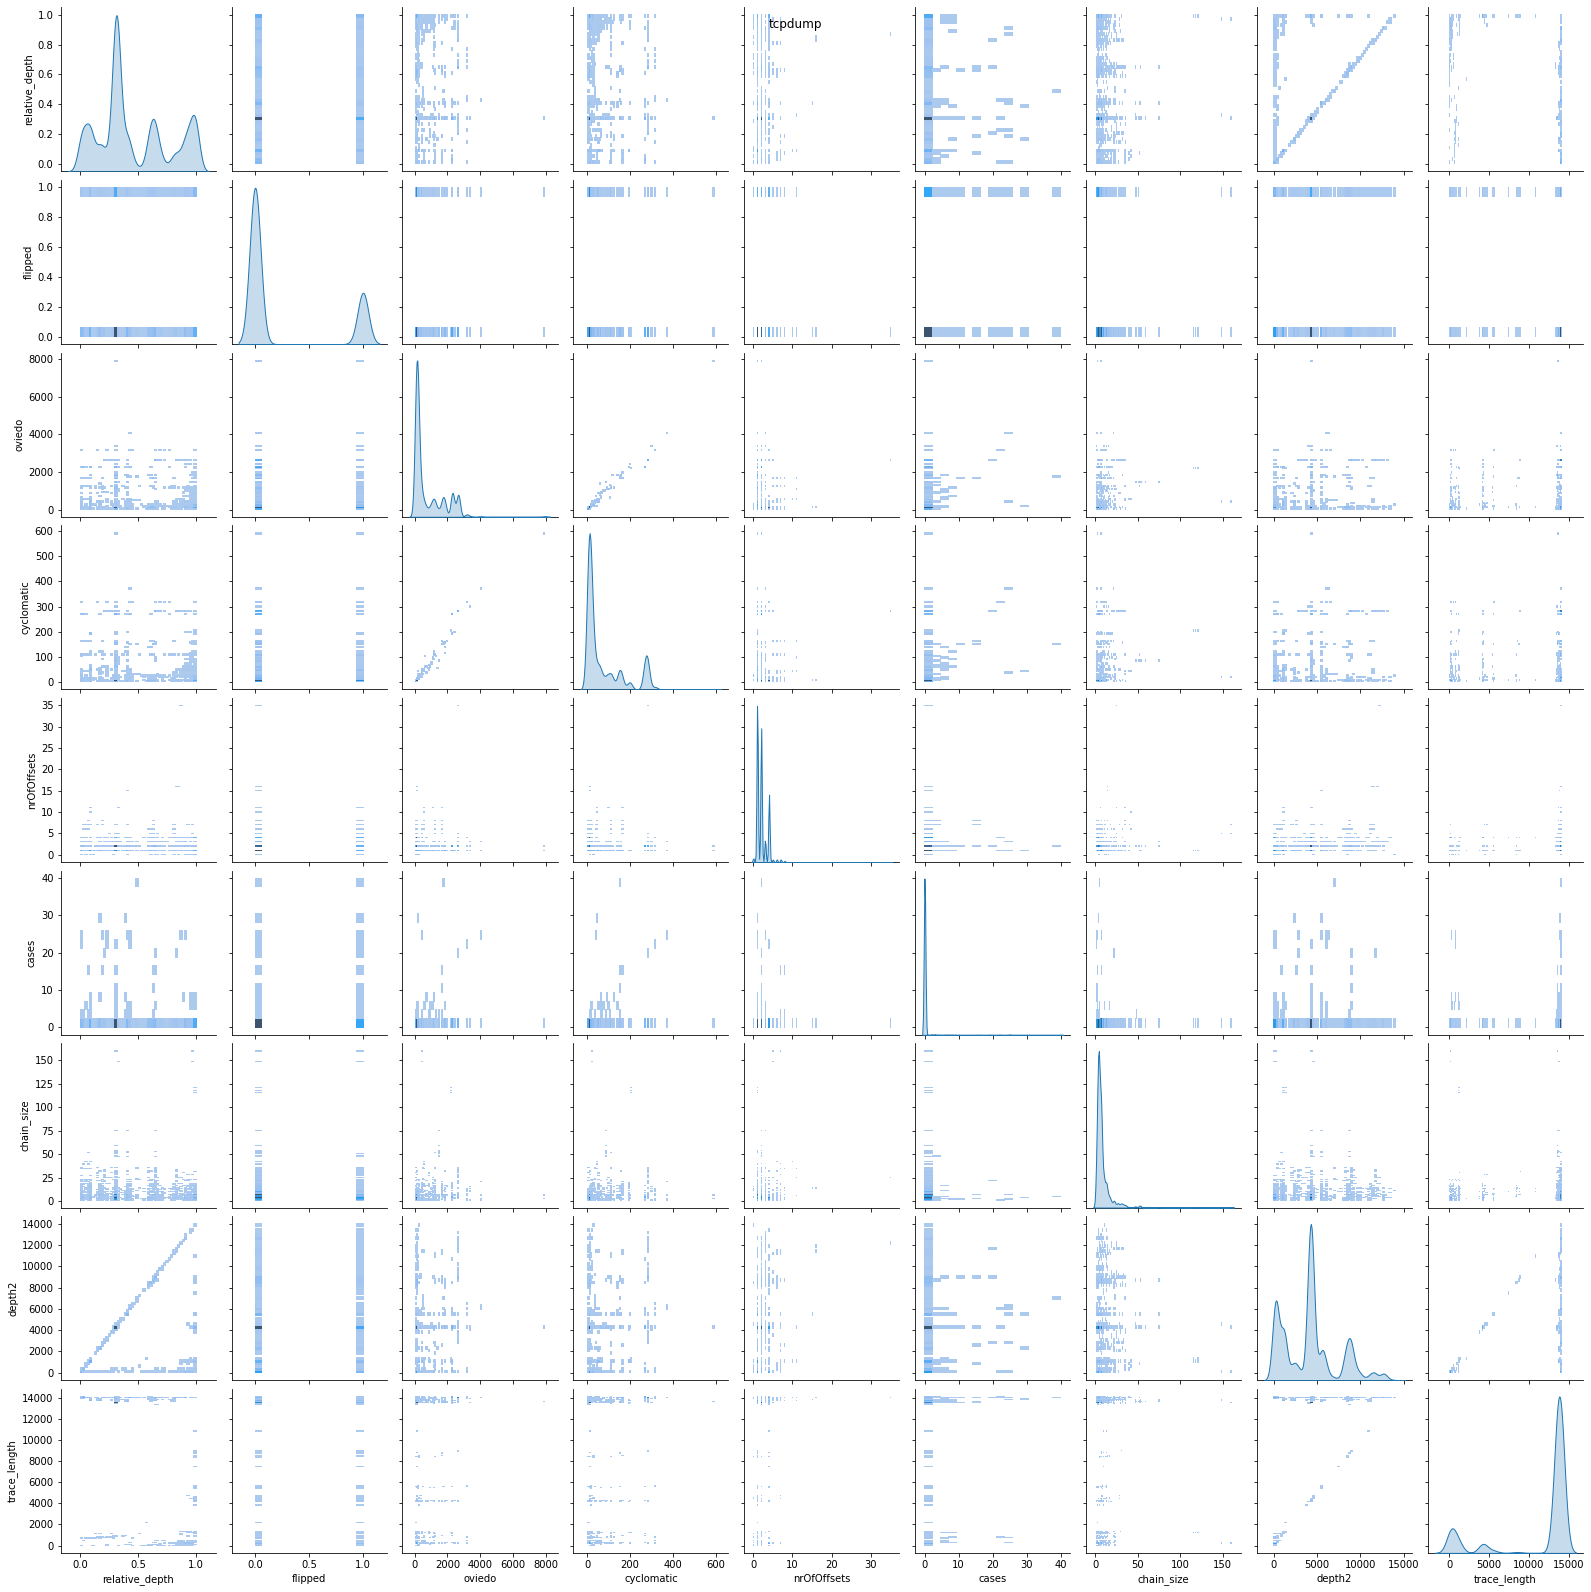

In [32]:
var_names = columns.copy()
var_names.remove("program")
var_names.remove("id")
var_names.remove("Strategy")
for program in programs:
    g = sns.pairplot(df_copy[df_copy.program == program], vars=var_names, kind="hist", diag_kind="kde")
    g.fig.suptitle(program)

### Correlation
We will calculate the correlation coefficients to see colinearity

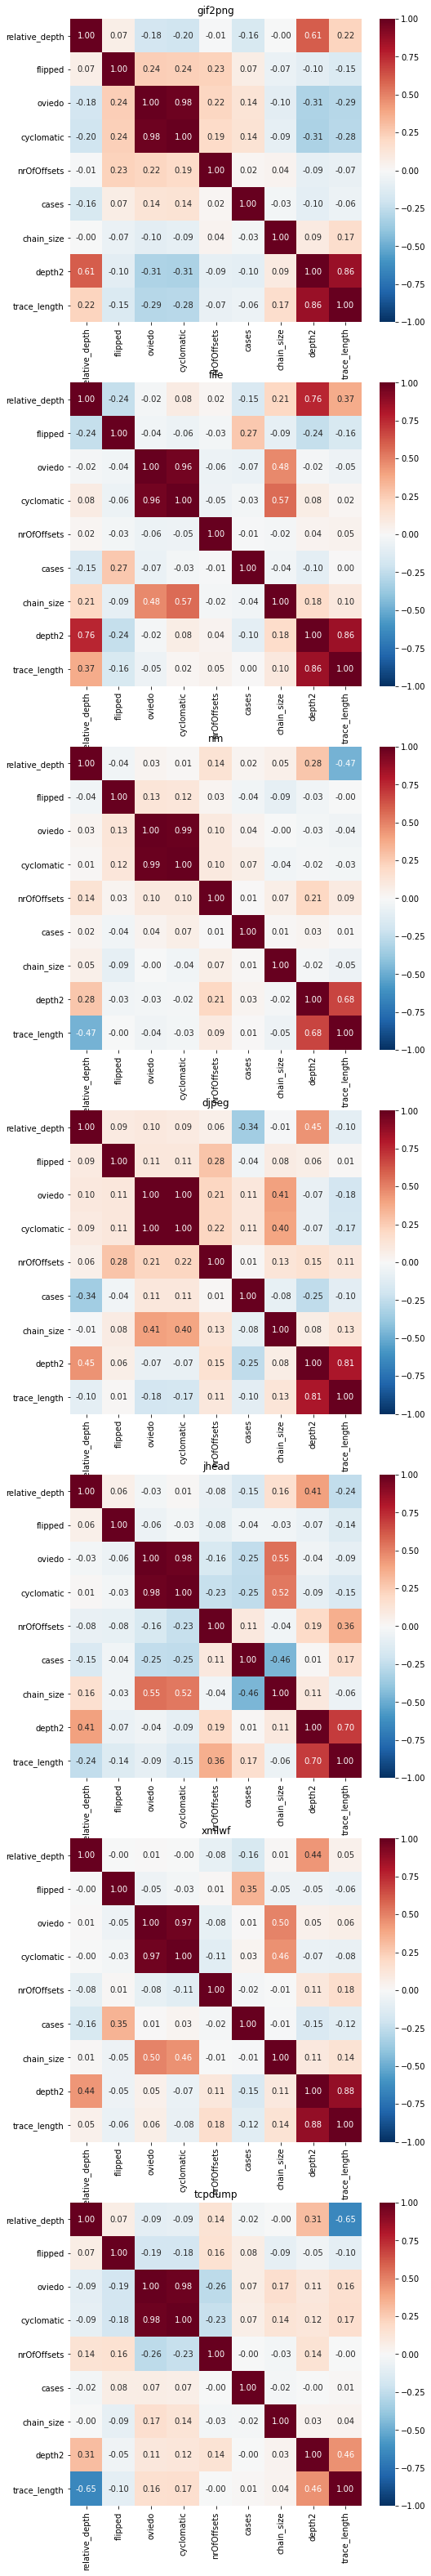

In [73]:
fig, axs = plt.subplots(nrows=programs.size, figsize=(8, programs.size * 8))
for ax, f in zip(axs, df_copy.program.unique()):
    ax.set_title(f)
    ax = sns.heatmap(df_copy[df_copy.program == f].corr(),
                    fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)
#fig.savefig("output.png", dpi=300)

We see a colinearity between the cyclomatic and oviedo variable.
Also between the depth2 and tracelength.

### Check histogram of all flipped conditions

Plotted gif2png relative_depth
Plotted gif2png oviedo
Plotted gif2png cyclomatic
Plotted gif2png nrOfOffsets
Plotted gif2png cases
Plotted gif2png chain_size
Plotted gif2png depth2
Plotted gif2png trace_length
Plotted file relative_depth
Plotted file oviedo
Plotted file cyclomatic
Plotted file nrOfOffsets
Plotted file cases
Plotted file chain_size
Plotted file depth2
Plotted file trace_length
Plotted nm relative_depth
Plotted nm oviedo
Plotted nm cyclomatic
Plotted nm nrOfOffsets
Plotted nm cases
Plotted nm chain_size
Plotted nm depth2
Plotted nm trace_length
Plotted djpeg relative_depth
Plotted djpeg oviedo
Plotted djpeg cyclomatic
Plotted djpeg nrOfOffsets
Plotted djpeg cases
Plotted djpeg chain_size
Plotted djpeg depth2
Plotted djpeg trace_length
Plotted jhead relative_depth
Plotted jhead oviedo
Plotted jhead cyclomatic
Plotted jhead nrOfOffsets
Plotted jhead cases
Plotted jhead chain_size
Plotted jhead depth2
Plotted jhead trace_length
Plotted xmlwf relative_depth
Plotted xmlwf ovi

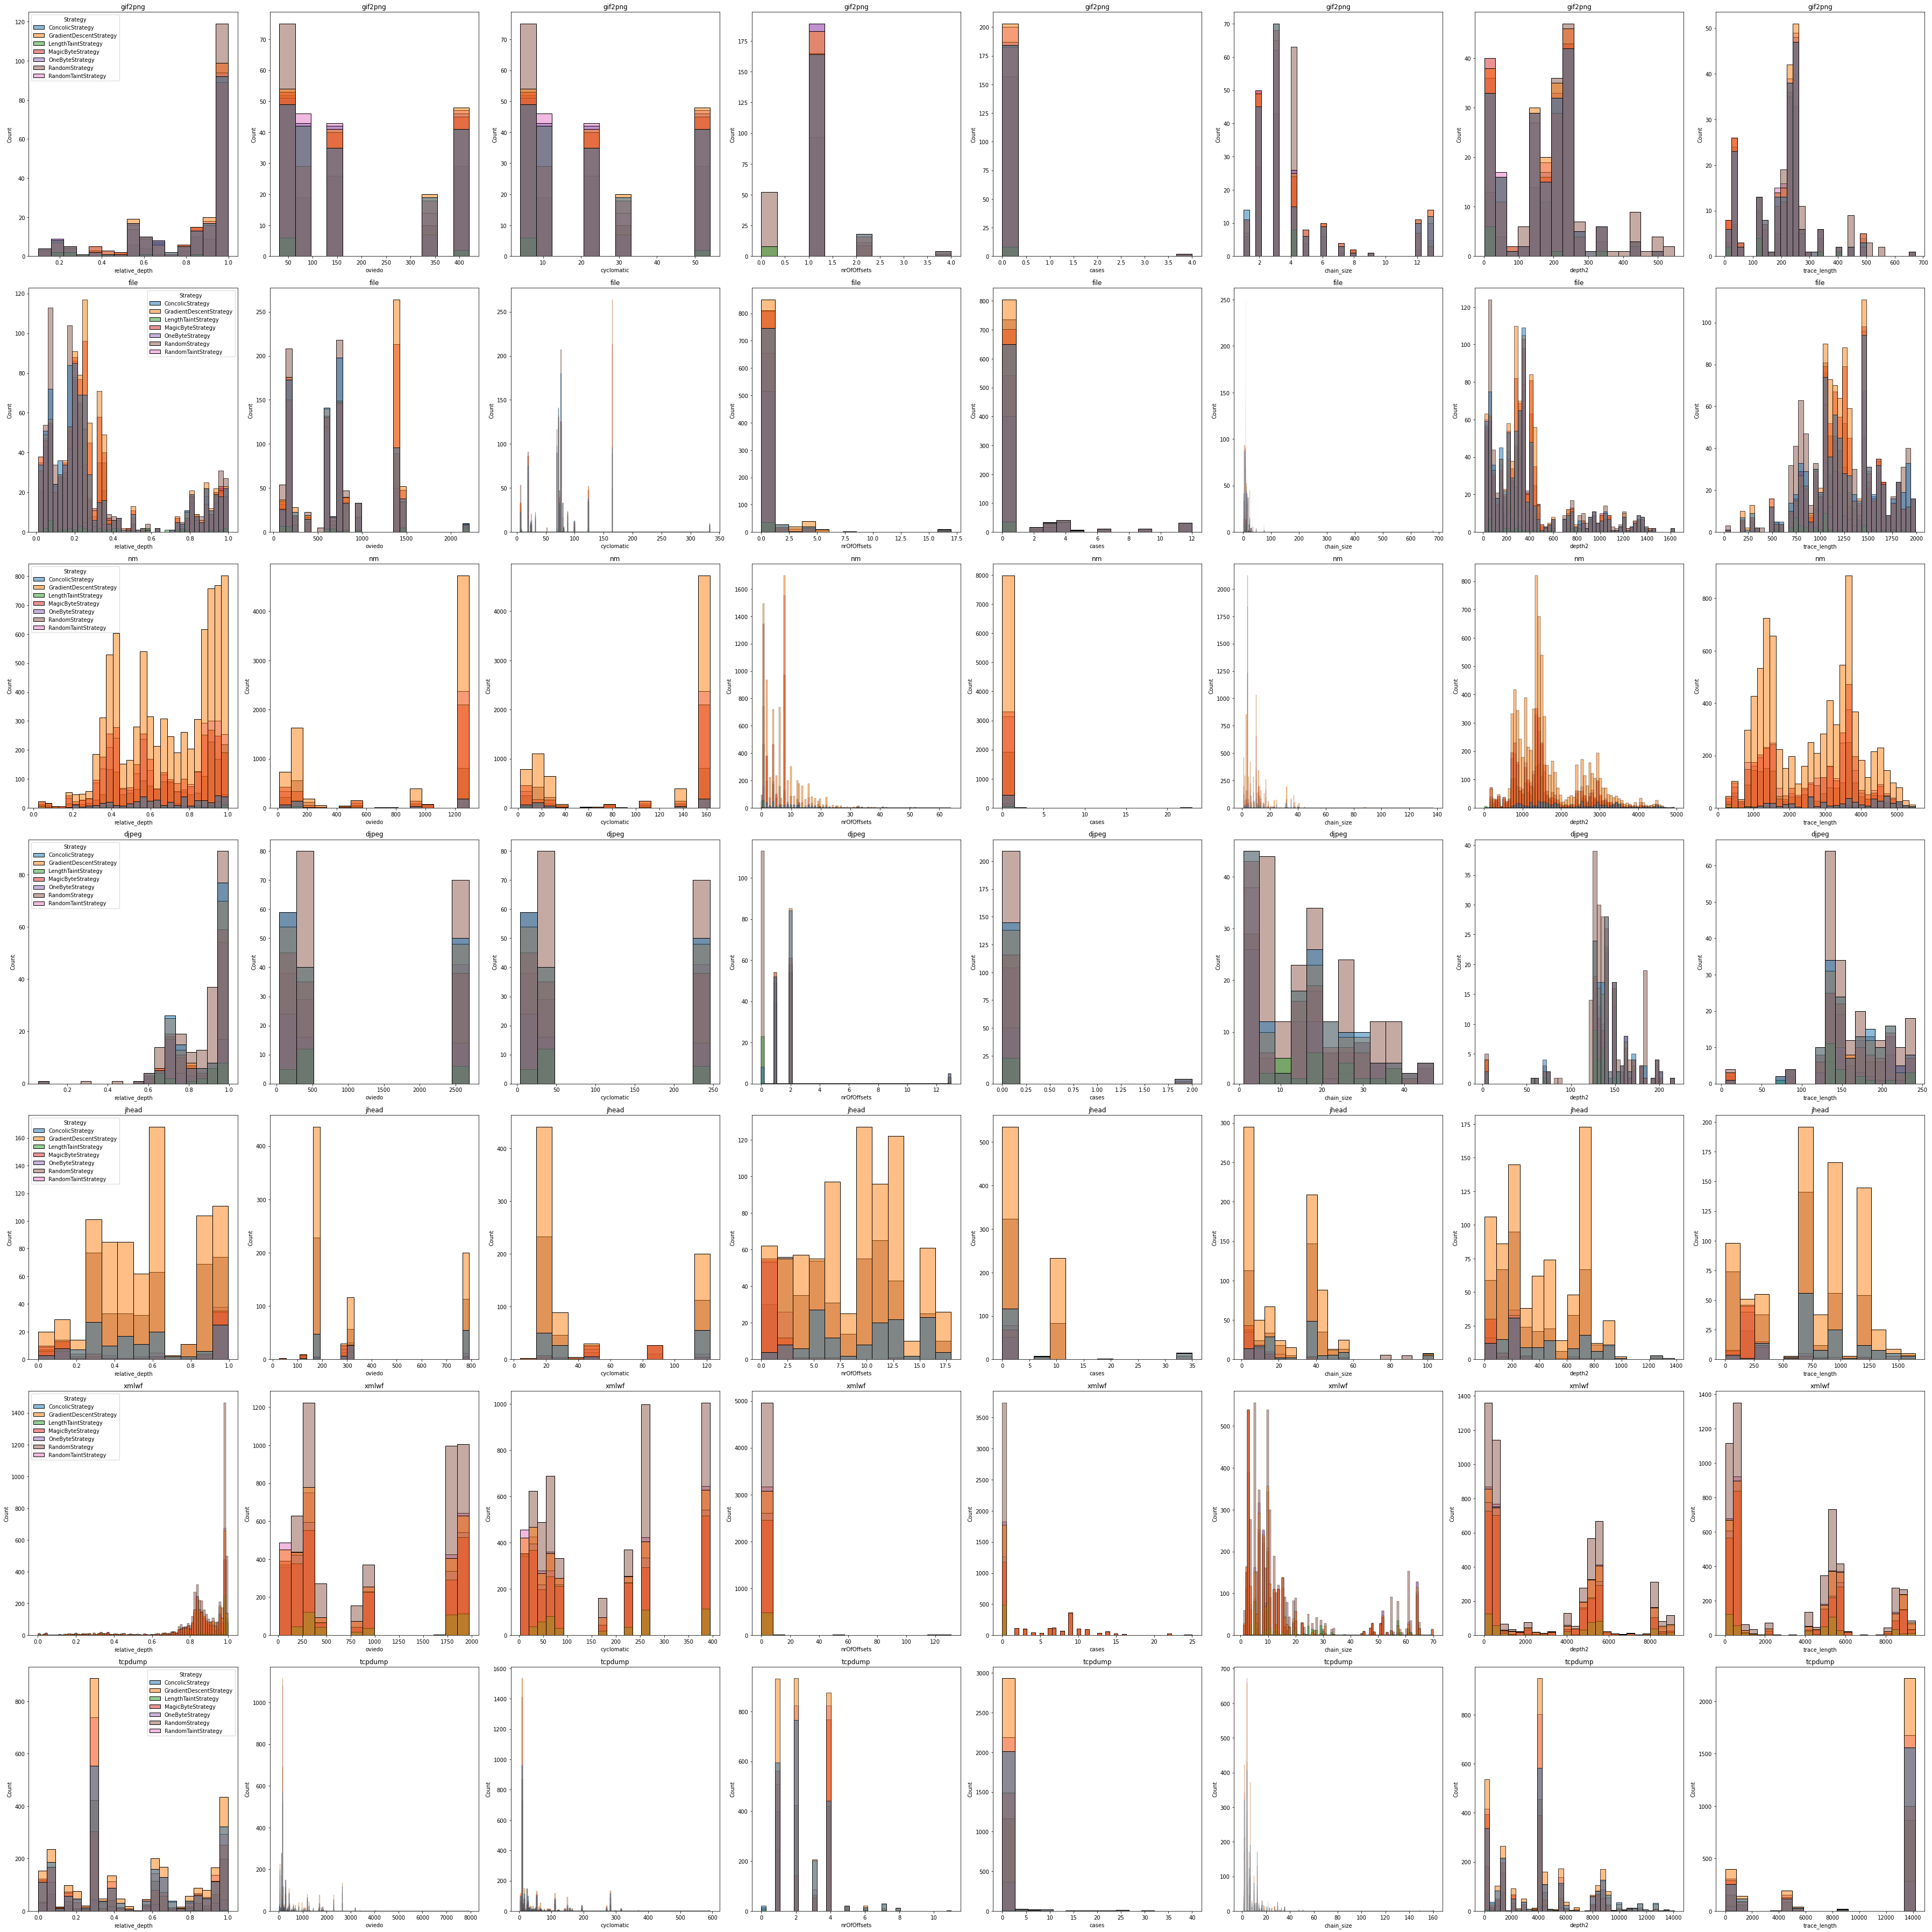

In [86]:
var_names_flipped = var_names.copy()
var_names_flipped.remove('flipped')
fig, axs = plt.subplots(len(programs),len(var_names_flipped), figsize=(50,50))
#axs = axs.flatten()

for ax_program, program in zip(axs, programs):
    first = True
    for ax, var_name in zip(ax_program, var_names_flipped):
        program_data = df_copy[(df_copy.program == program) & (df_copy.flipped == 1)].copy()
        g = sns.histplot(data=program_data, x=var_name, hue="Strategy", ax=ax)
        ax.title.set_text(program)
        print("Plotted %s %s" % (program, var_name))
        if not first:
            ax.get_legend().remove()
        first = False
plt.tight_layout()

### Create code to split in test and train set and cross validation

2 types of models:

- Classify flipped or not flipped based on properties
- Create for every strategy a time estimation to pick the minimal.

Do this on program basis and agregation basis AND compare the program level models with the difficult critical region statistic.

The first step is the feature selection.

In [96]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif

### Feature selection for classification

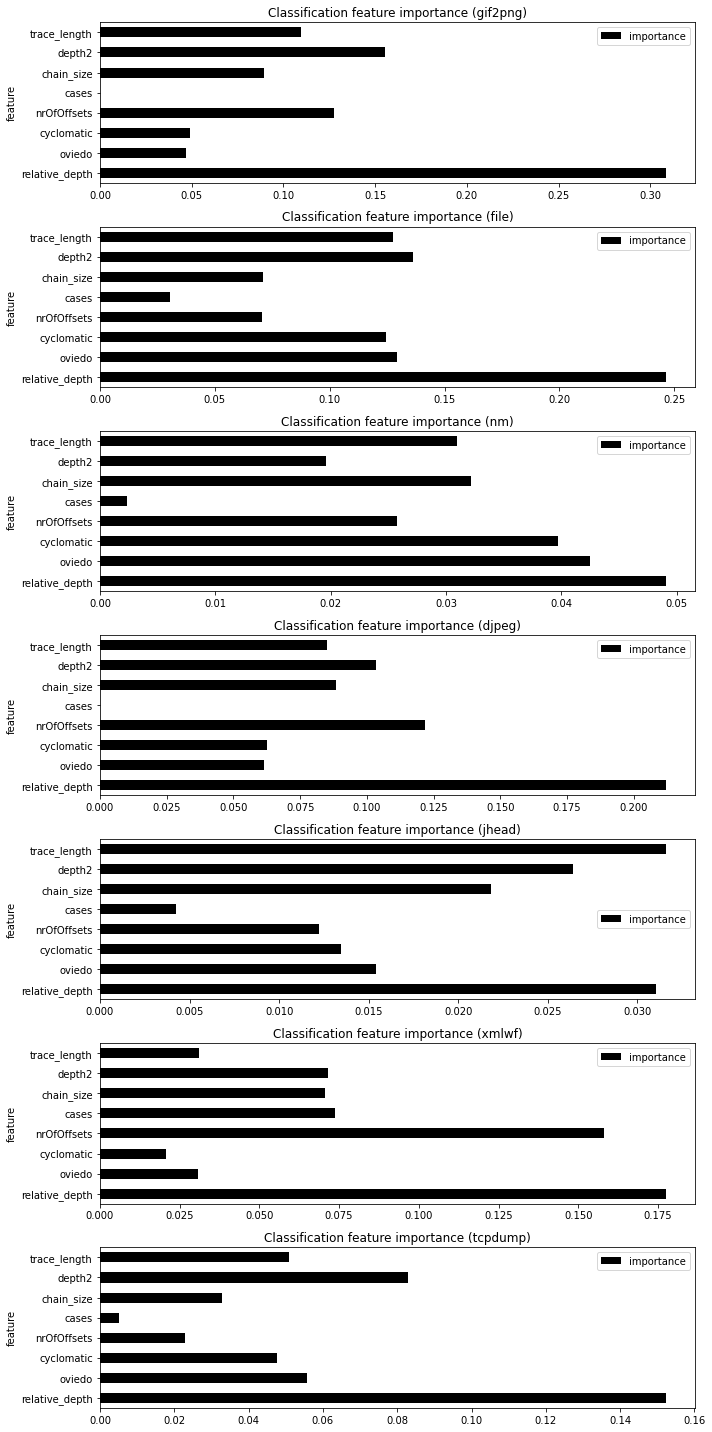

In [99]:
#construct all properties which can be flipped
all_features = ['relative_depth', 'oviedo', 'cyclomatic', 'nrOfOffsets', 'cases', 'chain_size', 'depth2', 'trace_length']
fig, axs = plt.subplots(nrows=len(programs), figsize=(10, 20))
for ax, program in zip(axs, programs):
    mic = mutual_info_classif(df_copy.loc[df_copy.program == program, all_features], df_copy.loc[df_copy.program == program, "flipped"], random_state=0)
    ax.set_title(f"Classification feature importance ({program})")
    ax = pd.DataFrame({"feature": list(all_features), "importance": mic}) \
            .set_index("feature").plot.barh(ax=ax, color="k")
plt.tight_layout()

From the graphs it is clear that the relative depth is the most important feature, the depth2 is used in the computation for the relative depth by dividing the trace length, so do not use this feature due to collinearity.
The chainsize, ovideo and nrOfOffsets are the next canidates, we discard the cyclomatic and cases, since cases is always the lowest and cyclomatic has a high collinearity with oviedo. The tracelengh is also used in the relative_depth so we discard this variable as well.

In [100]:
selected_features = ['relative_depth', 'oviedo',  'nrOfOffsets', 'chain_size']

# TODO: Create Mann-Whitney U test to see if they are significant!!!

### Create ML models for classification

In [160]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [168]:
TEST_MODELS = {
    "LinearSVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', LinearSVC(random_state=0))]),
        {"model__C":       [1, 10, 100, 1000, 10000]},
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "SVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', SVC(random_state=0))]),
        {
            "model__C":       [1, 10, 100, 1000, 10000],
            "model__gamma":   [.001, .01, .1, "scale"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "NuSVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', NuSVC(random_state=0))]),
        {
            "model__gamma":   [.001, .01, .1, "scale"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "Gausian": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', GaussianProcessClassifier(random_state=0))]),
        {'model__multi_class': ['one_vs_rest']},
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "DecisionTree": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', DecisionTreeClassifier (random_state=0))]),
        {
            "model__min_samples_leaf": [2**n for n in range(5)],
            "model__max_depth":       [None] + [2**n for n in range(8, 13)]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "NeuralNet": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', MLPClassifier(random_state=0))]),
        {
            'model__learning_rate': ["constant", "invscaling", "adaptive"],
            'model__hidden_layer_sizes': [(100,), (20,20), (20,20,20)],
            'model__alpha': [10.0 ** -n for n in range(1,7)],
            'model__activation': ["logistic", "relu", "Tanh"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),    
}

In [169]:
TEST_MODELS['LinearSVC'][0].get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__quantile_range', 'scaler__with_centering', 'scaler__with_scaling', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__loss', 'model__max_iter', 'model__multi_class', 'model__penalty', 'model__random_state', 'model__tol', 'model__verbose'])

In [ ]:

def test_classifier(program, data, selected_features, feature_to_classify):
    trained_models = {}
    fitted_models = {}
    for model_name, (model, grid, scoring) in TEST_MODELS.items():
        program_data = data[data.program == program]
        X_train, X_test, y_train, y_test = train_test_split(
            program_data[selected_features], 
            program_data[feature_to_classify],
            test_size=0.7
        )
        print("Training model %s with %s samples" % (model_name, len(X_train)))
        trained_models[model_name] = GridSearchCV(model, scoring=scoring, param_grid=grid, refit=scoring[0], n_jobs = -1)
        try:
            fitted = fitted_models[model_name] = trained_models[model_name].fit(X_train, y_train)
        except:
            print("Failed to fit model %s" % (model_name))
            continue
        print("Program %s for model %s had best score %s" % (program, model_name, fitted.best_score_))
        print(fitted.best_params_)
        print("Grid scores on development set:")
        #print(fitted.cv_results_)
        means = fitted.cv_results_['mean_test_accuracy']
        stds = fitted.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, fitted.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
        print()
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, fitted.predict(X_test)
        print(classification_report(y_true, y_pred))
    return (fitted_models, y_true, y_pred)

In [ ]:
model_results = {}
for program in programs:
    model_results[program] = test_classifier(program, df_copy, selected_features, "flipped")

### Create regressors, train models for every strategy and pick the one which takes the least amount of time.
Check if this corresponds with the real data.

To do this, we split the data from different strategies AND different programs.

In the end we will do a critical distance analysis.

In [ ]:

def test_regressor(program, data, selected_features, feature_to_classify):
    trained_models = {}
    fitted_models = {}
    for model_name, (model, grid, scoring) in TEST_MODELS.items():
        print("Training model %s" % model_name)
        program_data = data[data.program == program]
        X_train, X_test, y_train, y_test = train_test_split(
            program_data[selected_features], 
            program_data[feature_to_classify],
            test_size=0.7
        )
        trained_models[model_name] = GridSearchCV(model, scoring=scoring, param_grid=grid, refit=scoring[0], n_jobs = -1, random_state=0)
        try:
            fitted = fitted_models[model_name] = trained_models[model_name].fit(X_train, y_train)
        except:
            print("Failed to fit model %s" % (model_name))
            continue
        print(program, model_name, fitted.best_score_)
        print(fitted.best_params_)
        print("Grid scores on development set:")
        #print(fitted.cv_results_)
        means = fitted.cv_results_['mean_test_accuracy']
        stds = fitted.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, fitted.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
        print()
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, fitted.predict(X_test)
        print(classification_report(y_true, y_pred))
    return (fitted_models)

### If you have time, create metric to count number of previously seen offsets in input and rerun previous stuff